# Libraries

In [1]:
import cv2
import numpy as np
import requests
import json
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import io

# Video Question Answering System using LLaVA

Our VideoQASystem leverages [LLaVA](https://llava-vl.github.io/), a state-of-the-art open-source multimodal model that combines vision and language understanding. While LLaVA was originally designed for single-image multimodal interactions, we extend its capabilities to video analysis through sequential frame processing. The system demonstrates how open-source multimodal AI can understand both visual content and natural language queries to enable intelligent video analysis.

**System Architecture**

1. **Video Processing**:
  - Extracts key frames uniformly from video (4 frames by default)
  - Processes each frame independently through LLaVA's multimodal encoder
  - Combines insights from multiple frames for temporal understanding

2. **Question Answering Pipeline**:
  - Takes free-form questions about video content
  - Analyzes each frame with LLaVA's multimodal capabilities
  - Synthesizes observations into coherent answers using Llama-2 LLM
  - Displays video alongside answers for reference

3. **Question Generation**:
  - Generates relevant questions from video descriptions
  - Creates diverse questions focusing on visible content
  - Automatically answers generated questions using multimodal analysis
  - Shows both video and original description

**Implementation Details**
- Uses open-source Ollama API to access LLaVA's multimodal capabilities
- Converts frames to base64 for API compatibility
- Handles both direct questions and auto-generated questions
- Provides comprehensive multimodal analysis with video display

**Key Features**
- Zero-shot multimodal understanding
- Multi-frame temporal analysis
- Natural language interaction
- Visual context preservation
- Automated question generation and answering

The system leverages open-source tools and LLaVA's powerful multimodal capabilities to bridge the gap between visual understanding and natural language processing, enabling sophisticated video analysis through sequential frame processing and temporal context integration. This open-source implementation makes advanced video understanding accessible and customizable for various applications.

In [2]:
class VideoQASystem:
    def __init__(self, df, video_base_path="test_1k_compress"):
        self.df = df
        self.video_base_path = video_base_path

    def extract_frames(self, video_id: str, num_frames: int = 4):
        """Extract frames from video"""
        video_path = f"{self.video_base_path}/{video_id}.mp4"
        cap = cv2.VideoCapture(video_path)
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_to_sample = np.linspace(0, total_frames-1, num_frames, dtype=int)
        
        frames = []
        for frame_idx in frames_to_sample:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        
        cap.release()
        return frames

    def frame_to_base64(self, frame):
        """Convert numpy array frame to base64 string"""
        pil_image = Image.fromarray(frame)
        buffer = io.BytesIO()
        pil_image.save(buffer, format='JPEG', quality=95)
        return base64.b64encode(buffer.getvalue()).decode('utf-8')

    def display_video(self, video_id: str):
        """Display video and its description with thumbnail"""
        from PIL import Image
        import io
        
        video_desc = self.df[self.df['video_id'] == video_id]['sentence'].iloc[0]
        video_path = f"{self.video_base_path}/{video_id}.mp4"
        
        # Get video thumbnail
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()
        
        if ret:
            # Convert BGR to RGB using PIL
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame)
            
            # Save to base64 using PIL
            buffer = io.BytesIO()
            pil_image.save(buffer, format='JPEG', quality=95)
            img_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
            
            display(HTML(f"""
            <div style="border: 1px solid #ddd; padding: 15px; margin: 15px 0; border-radius: 5px;">
                <h3 style="margin-top: 0;">📽️ Video Analysis: {video_id}</h3>
                <p><b>📝 Description:</b> {video_desc}</p>
                
                <!-- Thumbnail for GitHub -->
                <img src="data:image/jpeg;base64,{img_base64}" 
                     alt="Video thumbnail" 
                     style="max-width: 500px; width: 100%; margin-bottom: 10px;">
                
                <!-- Video player (will work in Jupyter) -->
                <video width="500" controls>
                    <source src="{video_path}" type="video/mp4">
                    Your browser does not support the video tag.
                </video>
            </div>
            """))
        else:
            display(HTML(f"""
            <div style="border: 1px solid #ddd; padding: 15px; margin: 15px 0; border-radius: 5px;">
                <h3 style="margin-top: 0;">📽️ Video Analysis: {video_id}</h3>
                <p><b>📝 Description:</b> {video_desc}</p>
                <p>(Video preview not available: {video_path})</p>
                
                <video width="500" controls>
                    <source src="{video_path}" type="video/mp4">
                    Your browser does not support the video tag.
                </video>
            </div>
            """))

    def answer_question(self, video_id: str, question: str, show_video: bool = True):
        """Analyze video frames sequentially with LLaVA"""
        try:
            # Only display video if show_video is True
            if show_video:
                self.display_video(video_id)

            print(f"❓ Question: {question}\n")
            print("🔄 Analyzing frames...")

            frames = self.extract_frames(video_id, num_frames=4)

            # Analyze each frame
            frame_insights = []
            for i, frame in enumerate(frames, 1):
                print(f"Processing frame {i}/{len(frames)}...")
                frame_prompt = f"""Frame {i}/{len(frames)}
                Question: {question}
                Describe what you see in this frame that helps answer the question."""

                response = requests.post(
                    'http://opmlgpubuild01:11434/api/generate',
                    json={
                        'model': 'llava',
                        'prompt': frame_prompt,
                        'images': [self.frame_to_base64(frame)],
                        'stream': False
                    }
                )

                frame_insight = response.json().get('response', '').strip()
                if frame_insight:
                    frame_insights.append(frame_insight)

            # Synthesize final answer
            if frame_insights:
                synthesis_prompt = f"""Based on these observations:
                {' '.join(frame_insights)}

                Provide a clear and concise answer to: {question}"""

                final_response = requests.post(
                    'http://opmlgpubuild01:11434/api/generate',
                    json={
                        'model': 'llama3',
                        'prompt': synthesis_prompt,
                        'stream': False
                    }
                )

                answer = final_response.json().get('response', '').strip()
                print(f"\n💡 Answer: {answer}")
                return answer
            else:
                return "Could not analyze video frames."

        except Exception as e:
            return f"Error: {str(e)}"

    def analyze_video_with_questions(self, video_id: str):
        """Complete video analysis with auto-generated questions and answers"""
        # First display the video only once
        self.display_video(video_id)
        
        # Get video description
        video_desc = self.df[self.df['video_id'] == video_id]['sentence'].iloc[0]
        
        # Generate questions from description
        print("\n🤔 Generating relevant questions...")
        prompt = f"""Given this video description: "{video_desc}"
        Generate 5 specific and relevant questions about what might be shown in the video.
        Questions should focus on visible actions, objects, and details.
        Make questions diverse and interesting.
        Return only the questions, one per line."""
        
        try:
            response = requests.post(
                'http://opmlgpubuild01:11434/api/generate',
                json={
                    'model': 'llama3',
                    'prompt': prompt,
                    'stream': False
                }
            )
            
            questions = [q.strip().lstrip('123456789.)- ') 
                        for q in response.json()['response'].strip().split('\n')
                        if '?' in q][:5]
            
            # Answer each question without showing video again
            print("\n📋 Questions & Answers:")
            for i, question in enumerate(questions, 1):
                print(f"\n{'-'*50}")
                print(f"Q{i}: {question}")
                # Pass show_video=False to avoid displaying video again
                print(f"A: {self.answer_question(video_id, question, show_video=False)}")
            
            print(f"\n{'-'*50}")
            
        except Exception as e:
            print(f"Error in analysis: {str(e)}")

# Data

We will use the 1K [MSR-VTT dataset](https://www.microsoft.com/en-us/research/publication/msr-vtt-a-large-video-description-dataset-for-bridging-video-and-language/), a subset of the Microsoft Research Video to Text dataset designed for open-domain video captioning

In [3]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/text_video_search.zip -O
! unzip -q -o text_video_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  210M  100  210M    0     0  2258k      0  0:01:35  0:01:35 --:--:-- 2290k


In [4]:
data = pd.read_csv('MSRVTT_JSFUSION_test.csv')[['video_id', 'sentence']]
data.head()

,video_id,sentence
0,video9770,a person is connecting something to system
1,video9771,a little girl does gymnastics
2,video7020,a woman creating a fondant baby and flower
3,video9773,a boy plays grand theft auto 5
4,video7026,a man is giving a review on a vehicle


# Video Q&A

The answer_question function takes a video ID and a question as input. It first displays the video and its original description. Then it extracts 4 key frames from the video, which are processed sequentially through LLaVA, a multimodal AI model. For each frame, LLaVA analyzes the visual content in context of the question and provides insights. Finally, these frame-by-frame insights are combined to generate a comprehensive answer that considers information from all parts of the video.


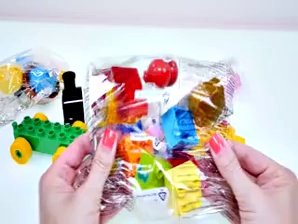

❓ Question: What are the main activities happening in this video?

🔄 Analyzing frames...
Processing frame 1/4...
Processing frame 2/4...
Processing frame 3/4...
Processing frame 4/4...

💡 Answer: The main activities happening in this video appear to be constructing or assembling something using Lego-like blocks, likely building structures or designs. The person is either preparing and organizing materials for a craft project or sorting through individual elements for use later. Additionally, there may be some disassembling of structures taking place as well.

Q: What are the main activities happening in this video?
A: The main activities happening in this video appear to be constructing or assembling something using Lego-like blocks, likely building structures or designs. The person is either preparing and organizing materials for a craft project or sorting through individual elements for use later. Additionally, there may be some disassembling of structures taking place as well.


In [5]:
# Initialize the system
video_qa = VideoQASystem(data)

# Test with the same video
video_id = "video8869"
question = "What are the main activities happening in this video?"

# Get answer
answer = video_qa.answer_question(video_id, question)
print(f"\nQ: {question}")
print(f"A: {answer}")

## Automatic Video Analysis

The analyze_video_with_questions function automatically processes a video in two steps: First, it uses the video's text description to generate relevant questions using an LLM (Llama-3). Then, for each generated question, it performs visual analysis using LLaVA to provide answers, displaying the video and its description alongside the Q&A results. This creates a comprehensive analysis of the video content through automatically generated and answered questions.


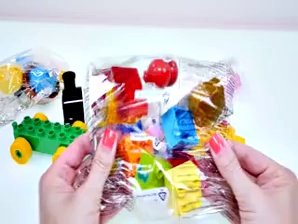


🤔 Generating relevant questions...

📋 Questions & Answers:

--------------------------------------------------
Q1: What is the name or logo printed on the box of toy building blocks?
❓ Question: What is the name or logo printed on the box of toy building blocks?

🔄 Analyzing frames...
Processing frame 1/4...
Processing frame 2/4...
Processing frame 3/4...
Processing frame 4/4...

💡 Answer: The name or logo printed on the box of toy building blocks is "LEGO."
A: The name or logo printed on the box of toy building blocks is "LEGO."

--------------------------------------------------
Q2: How many individual blocks does she pull out from the pack at the start of the video?
❓ Question: How many individual blocks does she pull out from the pack at the start of the video?

🔄 Analyzing frames...
Processing frame 1/4...
Processing frame 2/4...
Processing frame 3/4...
Processing frame 4/4...

💡 Answer: Based on the observations, it is not possible to determine the exact number of individual blo

In [ ]:
# Analyze a video with auto-generated questions
video_id = "video8869"
video_qa.analyze_video_with_questions(video_id)

# Additional Thoughts 

**Additional Enhancements for Video Q&A System:**

**Advanced Model Integration**

- Direct integration with [MiniGPT4-video](https://vision-cair.github.io/MiniGPT4-video/):
   * Replace frame-by-frame LLaVA analysis with single pass through MiniGPT4-video
   * Better temporal understanding and more coherent answers
   * Supports longer video context windows

- Object and action detection:
   * Use DINO-v2 to detect key objects and activities
   * Add detection results to prompts ("I see a person cooking, holding a pan...")
   * Create richer context for more accurate answers

- Scene segmentation:
   * Detect scene changes in video
   * Split questions/answers by relevant scenes
   * Enable temporal localization ("in the first scene...")

**Improved Analysis**

- Multi-turn conversations:
   * Keep conversation history and video context
   * Allow follow-up questions about previous answers
   * Enable clarifications and deeper exploration

- Timestamp-specific questions:
   * Link answers to specific video timestamps
   * Allow questions about specific moments
   * Navigate to relevant parts of video when answering

- Visual highlighting:
   * Overlay detected objects/actions on video
   * Show relevant regions for each answer
   * Help users understand model's focus areas

- Cross-video references:
   * Compare similar scenes across videos
   * Answer questions spanning multiple videos
   * Find related content in video database

This enhanced system would combine specialized video understanding with rich contextual information from detectors, enabling more precise and interactive video analysis.